In [ ]:
%%capture
'''
(C) Copyright 2020-2025 Murilo Marques Marinho (murilomarinho@ieee.org)

     This file is licensed in the terms of the
     Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)
     license.

 Derivative work of:
 https://github.com/dqrobotics/learning-dqrobotics-in-matlab/tree/master/robotic_manipulators
 Contributors to this file:
     Murilo Marques Marinho (murilomarinho@ieee.org)
'''

# DQ6 Robot Control Basics using DQ Robotics - Part 2

## I found an issue
Thank you! Please report it at https://github.com/MarinhoLab/OpenExecutableBooksRobotics/issues

## Introduction

In the last lesson, I introduced you to the basics of kinematic modeling and kinematic control using a 1-DoF planar robot. The main point of that lesson was to teach you how to develop your robots from scratch, if needed.


Nonetheless, the DQ Robotics library has many of those functionalities built-in. In this lesson, you will learn how to model serial manipulators using the Denavit-Hartenberg parameters and how to calculate important Jacobians using DQ Robotics. You will also learn how to create a basic kinematic controller using DQ Robotics.

In [ ]:
from math import sin, cos

import numpy as np

from dqrobotics import *
from dqrobotics_extensions.pyplot import plot

import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml" # Need to output animation's videos
import matplotlib.animation as anm
from functools import partial # Need to call functions correctly for matplotlib animations


## Introduction

In the last lesson, I introduced you to the basics of kinematic modeling and kinematic control using a 1-DoF planar robot. The main point of that lesson was to teach you how to develop your robots from scratch, if needed.


Nonetheless, the DQ Robotics library has many of those functionalities built-in. In this lesson, you will learn how to model serial manipulators using the Denavit-Hartenberg parameters and how to calculate important Jacobians using DQ Robotics. You will also learn how to create a basic kinematic controller using DQ Robotics.

<a name="H_D4ECB91A"></a>
## Notation

Keep these in mind (we will also use this notation when writting papers to conferences and journals):

-  $h\in \mathbb{H}$ : a quaternion. (Bold-face, lowercase character)
-  $\underline{h} \in \mathcal{H}$ : a dual quaternion. (Bold-face, underlined, lowercase character)
-  $p,t,\cdots \in {\mathbb{H}}_p$ : pure quaternions. They represent points, positions, and translations. They are quaternions for which $\textrm{Re}\left(h\right)=0$ .
-  $r\in {\mathbb{S}}^3$ : unit quaternions. They represent orientations and rotations. They are quaternions for which $||h||=1$ .
-  $\underline{x} \in$ $\underline{\mathcal{S}}$ : unit dual quaternions. They represent poses and pose transformations. They are dual quaternions for which $||h||=1$ .
-  $\underline{l} \in {\mathcal{H}}_p \cap$ $\underline{{\mathcal{S}}}$ : a Plücker line.
-  $\underline{{{\pi }}} \in \left\lbrace P\left(\underline{{{\pi }}} \right)\in {\mathbb{H}}_p \right\rbrace \cap \underline{{\mathcal{S}}}$ : a plane.
<a name="H_C7A69651"></a>
## Problem Definition
<p style="text-align:left">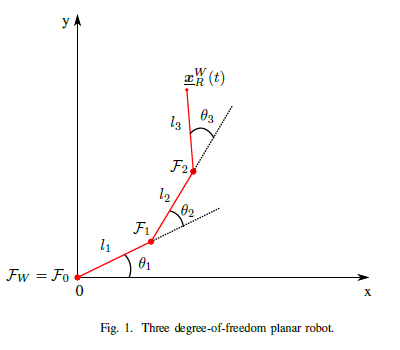</p>


1.  Let the robot $R$ be a 3-DoF planar robot, as drawn in Fig.1.
2. Let ${\mathcal{F}}_W$ be the world-reference frame.
3. Let ${\underline{x} }_R^W (t)\triangleq {\underline{x} }_R$ $\in$ $\underline{\mathcal{S}}$ represent the pose of the *end effector*.
4. Let $R$ be composed of three rotational joints that rotates about their z-axis, composed in the joint-space vector $q\left(t\right)\triangleq q={\left\lbrack \theta_1 ~\theta_2 ~\theta_3 \right\rbrack }^T$ with $\theta_1 \left(t\right)\triangleq \theta_1 ,\theta_2 \left(t\right)\triangleq \theta_2 ,\theta_3 \left(t\right)\triangleq \theta_3 \in \mathbb{R}$ . The rotation of the reference frames of each joint coincide with the rotation of ${\mathcal{F}}_W$ when $\theta_1 =\theta_2 =\theta_3 =0$ . The length of the links are $l_1 ,l_2 ,l_3 \in$ ${\mathbb{R}}^+ -\lbrace 0\rbrace$ .
5. Consider that we can freely control the joint vector $q$ .

Problems:

1.  Obtain the (pose) foward kinematic model of the robot $R$ using a set of DH parameters.
2. Obtain the pose Jacobian, rotation Jacobian, and translation Jacobian of $R$ .
3. Using 1. and 2., design a closed-loop pose controller, rotation controller, and translation controller.
<a name="H_08B34616"></a>
## Modeling serial robots using Denavit-Hartenberg Parameters

In the last lesson, you modelled a 2-DoF planar robot. As the number of DoF and the complexity of the robots increase, modeling them requires a more general, systematic, and scalable strategy. In this lesson we will show how serial manipulators are modeled using the Denavit-Hartenberg (DH) parameters. This is the standard methodology used in DQ robotics for modeling serial robots.

<a name="H_8AC9B033"></a>
### Forward Kinematic Model using DH parameters

For robots in 3D space, obtaining the robot's pose transformation is the most generic form of FKM for the end effector. When using unit dual quaternions, retrieving the rotation, translation, etc from the pose is quite straighforward. So let us obtain the pose FKM of the robot $R$ using the DH parameters.


Before going into detail about the DH parameters, let ${\underline{x} }_0^W \in \underline{{\mathcal{S}}}$ be the reference frame at the base of the robot. For convenience, it can coincide with the reference frame of the first joint of the robot.


The first joint enacts a pose transformation from the reference frame of the first joint to the reference frame of the second joint given by


$${\underline{ x } }_1^0 \left(\theta_1 \right)\triangleq {\underline{ x } }_1^0 \in \underline{{\mathcal{S}}}$$

that depends on the joint value of the first joint.


Given that the 3-DoF planar robot has three joints, the robot can be modeled with three consecutive transformations


$${\underline{ x } }_R ={\underline{ x } }_1^0 {\underline{ x } }_2^1 {\underline{ x } }_3^2 ,$$

where ${\underline{x} }_2^1 \left(\theta_2 \right)\triangleq {\underline{x} }_2^1 \in \underline{{\mathcal{S}}}$ and ${\underline{x} }_3^2 \left(\theta_3 \right)\triangleq {\underline{x} }_3^2 \in \underline{{\mathcal{S}}}$ . This sequence of transformation is a methodology that can be used for a serial manipulator with any number of joints.


The DH parameters provide a systematic way to calculate each individual joint transformation of any n-DoF serial manipulator.  Each joint transformation, ${\underline{x} }_i^{i-1} \left(\theta_i \right)\triangleq {\underline{x} }_i^{i-1} \in \underline{{\mathcal{S}}}$ , with $i=1,2,3\ldotp \ldotp \ldotp n$ is composed of four intermediate transformations, as follows


$${\underline{ x } }_i^{i-1} \triangleq {\underline{ x } }_{i^{\prime } }^i \left(\theta_i \right){\underline{ x } }_{i^{\prime \prime } }^{i^{\prime } } \left(d_i \right){\underline{ x } }_{i^{\prime \prime \prime } }^{i^{\prime \prime } } \left(a_i \right){\underline{ x } }_i^{i^{\prime \prime \prime } } \left(\alpha_i \right),$$

where the DH parameters, for each joint, are $\theta_i ,d_i ,a_i ,\alpha_i \in \mathbb{R}$ . Each of those parameters is related to one transformation. The first is the rotation of $\theta_i$ about the z-axis of frame ${\mathcal{F}}_{i-1}$


$${\underline{ x } }_{i^{\prime } }^{i-1} \left(\theta_i \right)=\cos \left(\frac{\theta_i }{2}\right)+\hat{k} \sin \left(\frac{\theta_i }{2}\right),$$

the second is a translation of $d_i$ about the z-axis of frame ${\mathcal{F}}_{i^{\prime } }$ ,


$${\underline{ x } }_{i^{\prime \prime } }^{i^{\prime } } \left(d_i \right)=1+\varepsilon \frac{1}{2}\hat{k} d_i ,$$

the third is the translation of $a_i$ about the x-axis of frame ${\mathcal{F}}_{i^{\prime \prime } }$ ,


$${\underline{ x } }_{i^{\prime \prime \prime } }^{i^{\prime \prime } } \left(a_i \right)=1+\varepsilon \frac{1}{2}\hat{\imath} a_i ,$$

the fourth, and last, is the rotation of $\alpha_i$ about the x-axis of frame ${\mathcal{F}}_{i^{\prime \prime \prime } }$


$${\underline{ x } }_i^{i^{\prime \prime \prime } } \left(\alpha_i \right)=\cos \left(\frac{\alpha_i }{2}\right)+\hat{\imath} \sin \left(\frac{\alpha_i }{2}\right).$$

Back to our example, the following table summarizes the DH parameters of the 3-DoF planar robot.

<p style="text-align:left">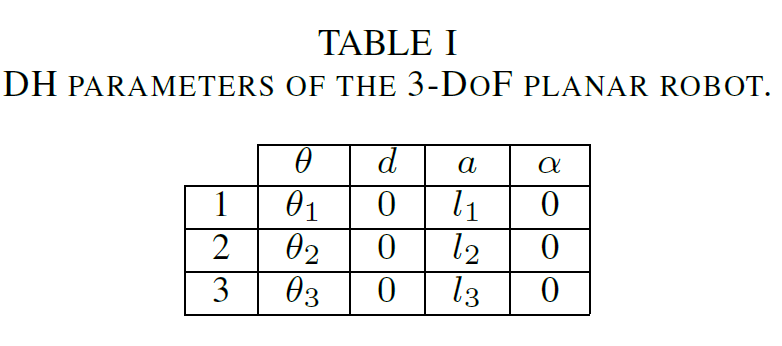</p>

<a name="H_AA707DEE"></a>
#### DQ Robotics Example

Let us create a class representing the 3-DoF planar robot using DH parameters. The good news is that most of the hard work is handled by DQ Robotics, using the following class


In [ ]:
from dqrobotics.robot_modeling import DQ_SerialManipulatorDH
help(DQ_SerialManipulatorDH)

Let us represent our robot in the following way, for $l_1 =l_2 =l_3 =1$ .

In [ ]:
from lesson6.three_dof_planar_robot_dh import ThreeDofPlanarRobotDH
help(ThreeDofPlanarRobotDH.kinematics)

Note that we use

In [ ]:
## This isn't currently exposed in Python and will be fixed in the next release
# DQ_SerialManipulatorDH.JOINT_ROTATIONAL;


to define a rotational joint, so we do not explicilty define $\theta_1 ,\theta_2 ,\theta_3$ in our model.


To calculate the forward kinematics model and plot the robot model, we can simply call the methods already available in the class, as follows


In [ ]:
# Initial joint values [rad]
theta1 = -0.1
theta2 = 0.55
theta3 = -1.02

# Joint vector
q = [theta1, theta2, theta3]

# Instantiate the robot kinematics
three_dof_planar_robot = ThreeDofPlanarRobotDH.kinematics()

# Get the fkm, based on theta
x_r = three_dof_planar_robot.fkm(q)

# Plot the robot
plt.figure()
ax = plt.axes(projection='3d')
ax.set_proj_type('ortho')
ax.view_init(azim=0, elev=90) #https://stackoverflow.com/questions/33084853/set-matplotlib-view-to-be-normal-to-the-x-y-plane-in-python
plt.xlabel('x [m]')
plt.ylabel('y [m]')
ax.set_zticks([])
plot(three_dof_planar_robot, q=q)


For more details about the methods, check the documentation of the class using


In [ ]:
help(DQ_SerialManipulatorDH.fkm)

In [ ]:
help(plot)

<a name="H_20390A66"></a>
### Differential Kinematics Model using DH parameters

Similar to how we calculated the the DKM in the last lesson, the DKM can be calculated for any set of DH parameters.

<a name="H_254642B8"></a>
#### Pose Jacobian

Using the FKM, we find


$${\textrm{vec}}_8 \left({\dot{\underline{ x } } }_R \right)=\frac{\partial \left({\textrm{vec}}_8 \left({\underline{ x } }_R \right)\right)}{\partial q}\dot{q} ,$$

where $J_{{\underline{x} }} \triangleq \frac{\partial \left({\textrm{vec}}_8 \left({\underline{x} }_R \right)\right)}{\partial q}$ is the pose Jacobian. We do not need to worry about the details of how to calculate this for now. The details of how to calculate the Jacobian for any serial manipulator are described from Page 38 of


ADORNO, B. V., Two-arm manipulation: from manipulators to enhanced human-robot collaboration [*Contribution à la manipulation à deux bras : des manipulateurs à la collaboration homme-robot*], Université Montpellier 2, Montpellier, France, 2011. ([pdf](https://adorno.eng.ufmg.br/publications/phd_thesis_final_version.pdf))

<a name="H_076EF171"></a>
#### Rotation Jacobian

The goal of this section is to find the rotation Jacobian, $J_r$ , so that the following relation holds


$${\textrm{vec}}_4 \left({\dot{r} }_R \right)=J_r \dot{q} .$$

The rotation Jacobian is useful to control the rotation of the end effector and can be used to calculate many other Jacobians.


We can conveniently find the rotation Jacobian using the pose Jacobian. To do so, remember that the robot's end-effector pose can be decomposed as follows


$${\underline{ x } }_R =r_R +\frac{1}{2}\varepsilon t_R r_R .$$

That means that the first-order time-derivative is


$${\textrm{vec}}_8 \left({\dot{\underline{ x } } }_R \right)={\textrm{vec}}_8 \left(P\left({\dot{\underline{ x } } }_R \right)\right)+{\textrm{vec}}_8 \left(D\left({\dot{\underline{ x } } }_R \right)\right)$$

that can be re-written as


$$J_{{\underline{ x } }} \dot{q} =\left\lbrack \begin{array}{c} J_{P\left({\underline{ x } }\right)} \\ 0 \end{array}\right\rbrack \dot{q} +\left\lbrack \begin{array}{c} 0\\ J_{D\left({\underline{ x } }\right)}  \end{array}\right\rbrack \dot{q}$$

which means that the pose Jacobian can be decomposed as


$$J_{{\underline{ x } }} \dot{q} =\left\lbrack \begin{array}{c} J_{P\left({\underline{ x } }\right)} \\ J_{D\left({\underline{ x } }\right)}  \end{array}\right\rbrack \dot{q} .$$

Notice that


$$J_{P\left({\underline{ x } }\right)} \dot{q} ={\textrm{vec}}_4 \left({\dot{r} }_R \right)$$

$$J_{P\left({\underline{ x } }\right)} \dot{q} =J_r \dot{q}$$

which means that the rotation Jacobian is  $J_r =J_{P\left({\underline{x} }\right)}$ . That is, the rotational Jacobian is composed of the first four rows of the pose Jacobian.

<a name="H_2FEB9F8A"></a>
#### Translation Jacobian

The goal of this section is to find the translation Jacobian, $J_t$ , so that the following relation holds


$${\textrm{vec}}_4 \left({\dot{t} }_R \right)=J_t \dot{q}$$

The translation Jacobian is useful to control the translation of the end effector and can be used to calculate many other Jacobians. We can conveniently find the translation Jacobian using the pose Jacobian and the end-effector's pose.


We start from the translation relation


$$t_R =\textrm{translation}\left({\underline{ x } }_R \right)=2D\left({\underline{ x } }_R \right)P{\left({\underline{ x } }_R \right)}^*$$

$${\dot{t} }_R =2\left\lbrack D\left({\dot{\underline{ x } } }_R \right)P{\left({\underline{ x } }_R \right)}^* +D\left({\underline{ x } }_R \right)P{\left({\dot{\underline{ x } } }_R \right)}^* \right\rbrack$$

$${\textrm{vec}}_4 \left({\dot{t} }_R \right)=2\left\lbrack \overset{-}{\underset{4}{H}} \left(P{\left({\underline{ x } }_R \right)}^* \right)J_{D\left({\underline{ x } }\right)} +\overset{+}{\underset{4}{H}} \left(D\left({\underline{ x } }_R \right)\right)C_4 J_{P\left({\underline{ x } }\right)} \right\rbrack \dot{q}$$

hence


$$J_t =2\left\lbrack \overset{-}{\underset{4}{H}} \left(P{\left({\underline{ x } }_R \right)}^* \right)J_{D\left({\underline{ x } }\right)} +\overset{+}{\underset{4}{H}} \left(D\left({\underline{ x } }_R \right)\right)C_4 J_{P\left({\underline{ x } }\right)} \right\rbrack .$$
<a name="H_7BB8E5F4"></a>
#### DQ Robotics Example

The pose Jacobian can be computed using the DQ_SerialManipulatorDH class as follows.


In [ ]:
# Get the pose Jacobian
Jx = three_dof_planar_robot.pose_jacobian(q)


The rotation Jacobian and translation Jacobian can be calculated using methods of its DQ_Kinematics superclass. For instance, the rotation Jacobian can be obtained as


In [ ]:
# Get the rotation Jacobian, based on the pose Jacobian
Jr = three_dof_planar_robot.rotation_jacobian(Jx)


and the translation Jacobian can be obtained as


In [ ]:
# Get the end-effector's pose
x = three_dof_planar_robot.fkm(q)
# Get the translation Jacobian
Jt = three_dof_planar_robot.translation_jacobian(Jx,x)

## Task-space position control

In the last lesson you were introduced to the basics of robot control using the inverse differential kinematics model.

Instead of building the controller from scratch, you can use controllers already available in DQ Robotics.

### Pseudo-Inverse Controller

In the last lesson, we implemented a simple pseudo-inverse-based kinematic controller. Let us revisit this topic using DQ Robotics.

In [ ]:
from dqrobotics.robot_control import DQ_PseudoinverseController
from dqrobotics.robot_control import ControlObjective

#### Preliminaries

Let us start with the initial conditions of the problem.



Define the sampling time and how many seconds of control we will simulate.


In [ ]:
# Sampling time [s]
tau = 0.01
# Simulation time [s]
time_final = 1


Define the initial robot posture.


In [ ]:
# Initial joint values [rad]
theta1 = -0.4
theta2 = 1.71
theta3 = 0.85
# Arrange the joint values in a column vector
q_init = [theta1, theta2, theta3]

<a name="H_C50E6DDF"></a>

Define the desired translation


In [ ]:
# Desired translation components [m]
tx = 1.25
ty = 1.25
# Desired translation
td = tx*i_ + ty*j_


then, the desired rotation.


In [ ]:
# Desired rotation component [rad]
gamma = 0.49
# Desired rotation
rd = cos(gamma/2.0) + k_*sin(gamma/2.0)


The desired pose will then be


In [ ]:
# Desired pose
xd = rd + 0.5*E_*td*rd


We then instantiate the robot kinematics, as follows.


In [ ]:
# Create robot
three_dof_planar_robot = ThreeDofPlanarRobotDH.kinematics()

<a name="H_FB3C3DFC"></a>
#### Translation Controller

The basic syntax to instantiate a translation controller is as follows.


The robot will align the end-effector translation with the desired translation. The rotation is not controlled.


In [ ]:
# Instanteate the controller
translation_controller = DQ_PseudoinverseController(three_dof_planar_robot)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(5.0)
translation_controller.set_damping(0) # Damping was not explained yet, set it as 0 to use pinv()

# Translation controller loop.
q = q_init
stored_q = []
for time in np.arange(0, time_final + tau,tau):
    # Store q for posterior animation
    stored_q.append(q)

    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(td))

    # Move the robot
    q = q + u * tau

Plot related code with reusable functions `animate_robot` and `setup_plot`.

In [ ]:
# Animation function
def animate_robot(n, robot, stored_q, xd):
    plt.cla()
    plot(robot, q=stored_q[n])
    plot(xd)
    plt.xlabel('x [m]')
    plt.xlim([-0.3, 2])
    plt.ylabel('y [m]')
    plt.ylim([-2, 2])
    ax = plt.gca()
    ax.axes.zaxis.set_ticklabels([])
    plt.title(f'Translation control time={time} s out of {time_final} s')

def setup_plot():
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_proj_type('ortho')
    ax.view_init(azim=0, elev=90) #https://stackoverflow.com/questions/33084853/set-matplotlib-view-to-be-normal-to-the-x-y-plane-in-python
    return fig, ax

fig, ax = setup_plot()
anm.FuncAnimation(fig, 
                  partial(animate_robot, robot=three_dof_planar_robot, stored_q=stored_q, xd=xd), 
                  frames=len(stored_q))

<a name="H_D4B2C20F"></a>
#### Rotation Controller

The basic syntax to instantiate a rotation controller is as follows.


The robot will align the end-effector rotation with the desired rotation. The translation is not controlled.


In [ ]:
# Instantiate the controller
translation_controller = DQ_PseudoinverseController(three_dof_planar_robot)
translation_controller.set_control_objective(ControlObjective.Rotation)
translation_controller.set_gain(5.0)
translation_controller.set_damping(0) # Damping was not explained yet, set it as 0 to use pinv()

# Rotation controller loop.
q = q_init
stored_q = []
for time in np.arange(0, time_final + tau,tau):
    # Store q for posterior animation
    stored_q.append(q)
    
    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(rd));

    # Move the robot
    q = q + u * tau

The behavior can be seen as follows.

In [ ]:
# Plot
fig, ax = setup_plot()
anm.FuncAnimation(fig, 
                  partial(animate_robot, robot=three_dof_planar_robot, stored_q=stored_q, xd=xd), 
                  frames=len(stored_q))

<a name="H_53BC575B"></a>
#### Pose Controller

The basic syntax to instantiate a pose controller is as follows.


The robot will align the end-effector pose with the desired pose. If the rotation and translation cannot be achieved simulatenously, the robot will balance rotation and translation error, according to the controller definitions.


In [ ]:
# Instantiate the controller
translation_controller = DQ_PseudoinverseController(three_dof_planar_robot)
translation_controller.set_control_objective(ControlObjective.Pose)
translation_controller.set_gain(5.0)
translation_controller.set_damping(0) # Damping was not explained yet, set it as 0 to use pinv()

# Translation controller loop.
q = q_init
stored_q = []
for time in np.arange(0, time_final + tau,tau):
    # Store q for posterior animation
    stored_q.append(q)

    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec8(xd))

    # Move the robot
    q = q + u * tau


The behavior can be seen as follows.

In [ ]:
# Plot
fig, ax = setup_plot()
anm.FuncAnimation(fig, 
                  partial(animate_robot, robot=three_dof_planar_robot, stored_q=stored_q, xd=xd), 
                  frames=len(stored_q))

# Homework

(1) Following the format of `ThreeDofPlanarRobotDH.py`, create a class called `NDofPlanarRobotDH.py` as shown in the figure.

<p style="text-align:left">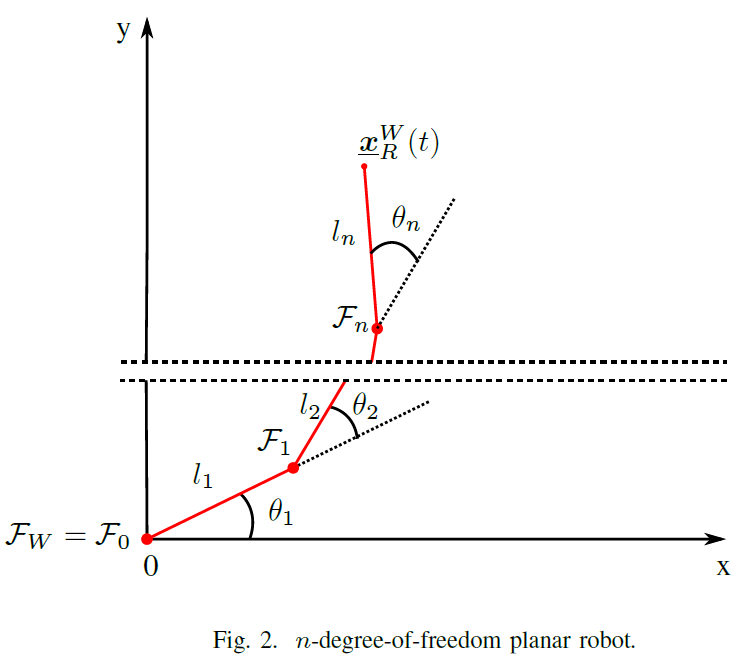</p>


The class must

1.  Consider all lengths of the links as unitary. That is, $l_1 =l_2 =\cdots =l_n =1$ .
2. Have a "kinematics" method that takes the desired number of DoFs as input and returns the corresponding `DQ_SerialManipulatorDH` instance.

(2) Consider the desired translation $t_d =5\hat{\imath} +2\hat{\jmath}$ , desired rotation $r_d =\cos \left(-\frac{\pi }{8}\right)+\hat{k} \sin \left(-\frac{\pi }{8}\right)$ , and initial posture $\theta_i (0)=\frac{\pi }{8}$ for $i=1...7$ . Use the class you created in (1) to instantiate a 7-DoF planar robot.

1.  create a script called `seven_dof_planar_robot_translation_control.m` that implements a task-space translation controller using a DQ_PseudoinverseController. Control the 7-DoF planar robot to $t_d .$
2. create a script called `seven_dof_planar_robot_rotation_control.m` that implements a task-space rotation controller using a DQ_PseudoinverseController. Control the 7-DoF planar robot to $r_d .$
3. create a script called `seven_dof_planar_robot_pose_control.m` that implements a task-space pose controller using a DQ_PseudoinverseController. Control the 7-DoF planar robot to ${\underline{x} }_d =r_d +\frac{1}{2}\varepsilon t_d r_d$ .
